In [64]:
from IPython.utils import io
import os
import subprocess
import tqdm.notebook



TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

In [65]:
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from collections import Counter
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from IPython.display import clear_output
import time

Global optimum value: -2.9486837251832947
Location: x=1.1616161616161618, y=-4.494949494949495


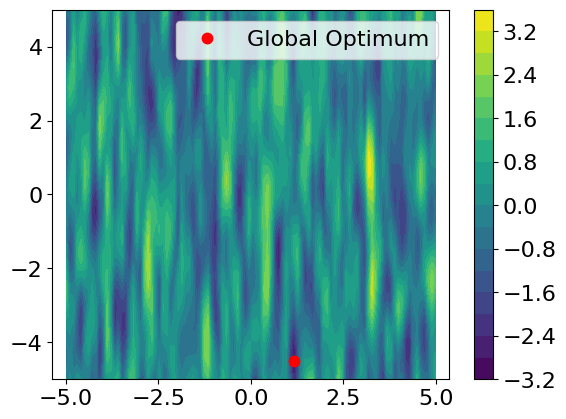

In [66]:
# グローバルで関数の形状を決定
N = 100
grid_points = np.linspace(-5, 5, N)
kernel = RBF(length_scale=[0.1, 1.0])
gpr = GaussianProcessRegressor(kernel=kernel)
X, Y = np.meshgrid(grid_points, grid_points)
XY = np.array([X.ravel(), Y.ravel()]).T
y = gpr.sample_y(XY, random_state=42).reshape(X.shape)

global_optimum = y.min()

# 最小値のインデックスを取得
min_idx = y.argmin()
j, i = np.unravel_index(min_idx, y.shape)

# 対応する座標を取得
x_opt = grid_points[i]
y_opt = grid_points[j]

print(f"Global optimum value: {global_optimum}")
print(f"Location: x={x_opt}, y={y_opt}")

plt.contourf(X, Y, y, levels=20)
plt.colorbar()
plt.plot(x_opt, y_opt, 'r.', markersize=15, label='Global Optimum')  # 赤い点を追加
plt.legend()  # 凡例を表示
plt.axis("equal")
plt.show()

In [67]:
def objective_function(x):
    # グリッド上の最も近い点を見つける
    if torch.is_tensor(x):
        x = x.numpy()
    
    x1, x2 = x[..., 0], x[..., 1]
    
    # バッチ処理に対応
    if isinstance(x1, np.ndarray):
        # 複数の入力点がある場合
        result = []
        for k in range(len(x1)):
            i = np.abs(grid_points - x1[k]).argmin()
            j = np.abs(grid_points - x2[k]).argmin()
            result.append(y[j, i])
        return torch.tensor(result, dtype=torch.float32)
    else:
        # 単一の入力点の場合
        i = np.abs(grid_points - x1).argmin()
        j = np.abs(grid_points - x2).argmin()
        return torch.tensor([y[j, i]], dtype=torch.float32)

In [68]:
class ECI_BO_Bandit:
    def __init__(self, X, objective_function, bounds, n_initial, n_max, dim, gamma=0.99):
        # dtypeを明示
        dtype = torch.float

        # 方向ベクトルをfloatで定義
        self.arms_features = torch.tensor([
            [1.0, 0.0],
            [0.0, 1.0],
            [1.0 / np.sqrt(2), 1.0 / np.sqrt(2)],
            [1.0 / np.sqrt(2), -1.0 / np.sqrt(2)]
        ], dtype=dtype)

        self.num_arms = self.arms_features.shape[0]

        # A, bもdtype指定
        self.A = torch.eye(dim, dtype=dtype)
        self.b = torch.zeros(dim, dtype=dtype)

        self.arm_counts = [1] * self.num_arms
        self.arm_rewards = [0.0] * self.num_arms
        self.squared_reward = [0.0] * self.num_arms

        # boundsやXもfloatに統一
        self.objective_function = objective_function
        self.bounds = bounds.to(dtype=dtype)
        self.n_initial = n_initial
        self.n_max = n_max
        self.dim = dim
        self.X = X.to(dtype=dtype)
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.gamma = 1.0
        self.eval_history = [self.best_value] * n_initial
        self.arm_selection_history = []
        self.optimization_history = []

    def update_model(self):
        kernel = ScaleKernel(RBFKernel(ard_num_dims=self.X.shape[-1]), noise_constraint=1e-5).to(self.X)
        self.model = SingleTaskGP(self.X, self.Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)

    def normalize_rewards(self, rewards):
        if isinstance(rewards, (int, float)):
            return rewards
        min_reward = min(rewards)
        max_reward = max(rewards)
        if min_reward == max_reward:
            return [1.0] * len(rewards)
        return [(r - min_reward) / (max_reward - min_reward) for r in rewards]

    def initialize(self):
        # objective_functionの出力もfloatに揃える
        y_val = self.objective_function(self.X)
        if y_val.dtype != torch.float:
            y_val = y_val.float()
        self.Y = y_val.unsqueeze(-1)
        self.best_value = self.Y.min().item()
        self.best_point = self.X[self.Y.argmin()]
        self.update_model()
        self.eval_history = [self.best_value] * self.n_initial

    def select_arm(self, total_iterations):
        A_inv = torch.inverse(self.A)
        theta = A_inv @ self.b
        p_values = []
        alpha = 1.0

        for i in range(self.num_arms):
            x_arm = self.arms_features[i].view(-1, 1)
            mean = (theta.view(1, -1) @ x_arm).item()
            var = (x_arm.t() @ A_inv @ x_arm).item()
            ucb = mean + alpha * math.sqrt(var * math.log(total_iterations + 1))
            p_values.append(ucb)

        return int(np.argmax(p_values))

    def optimize(self):
        self.initialize()
        self.optimization_history = []
        n = self.n_initial
        total_iterations = 1

        dtype = torch.float

        while n < self.n_max:
            self.update_model()

            # アーム（方向）を選ぶ
            selected_arm = self.select_arm(total_iterations)
            self.arm_selection_history.append(selected_arm)
            direction = self.arms_features[selected_arm]

            ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)

            def eci_func(x):
                # x: [batch_size, q=1, d=1]
                batch_size = x.shape[0]
                # xをスカラー列に変換
                x_scalar = x.squeeze(-1).squeeze(-1)  # [batch_size]
            
                # best_point: [2], direction: [2]
                # x_scalar[:, None]: [batch_size, 1]
                # → x_scalar[:, None] * direction: [batch_size, 2]
                full_x = self.best_point.clone().unsqueeze(0)  # [1,2]
                full_x = full_x + x_scalar[:, None] * direction  # [batch_size, 2]
            
                # EIは [batch_size, q=1, d=2] を想定
                full_x = full_x.unsqueeze(1)  # [batch_size, 1, 2]
            
                return ei(full_x)


            one_d_bounds = torch.tensor([[-5.0], [5.0]], dtype=dtype)

            candidate, acq_value = optimize_acqf(
                eci_func,
                one_d_bounds,
                q=1,
                num_restarts=10,
                raw_samples=100,
            )

            new_x = self.best_point.clone() + candidate.squeeze() * direction
            new_y = self.objective_function(new_x.unsqueeze(0)).unsqueeze(-1).to(dtype=dtype)

            self.X = torch.cat([self.X, new_x.unsqueeze(0)])
            self.Y = torch.cat([self.Y, new_y])

            self.optimization_history.append(new_x.clone())

            improvement = max(0, self.best_value - new_y.item())
            if improvement > 0:
                improvement = 1

            x_arm = self.arms_features[selected_arm].view(-1, 1)
            self.A = self.A + x_arm @ x_arm.t()
            self.b = self.b + improvement * self.arms_features[selected_arm]

            if new_y.item() < self.best_value:
                self.best_value = new_y.item()
                self.best_point = new_x

            self.eval_history.append(self.best_value)

            self.arm_counts[selected_arm] += 1
            n += 1
            total_iterations += 1

        return self.best_point, self.best_value

In [69]:
def generate_initial_points(n_initial, dim, bounds):
    return torch.rand(n_initial, dim) * (bounds[1] - bounds[0]) + bounds[0]

In [70]:
dim = 2
active_dim = 1
bounds = torch.tensor([[-5.0] * dim, [5.0] * dim])
n_initial = 100
n_iter = 500
n_runs = 1

In [71]:
eci_bo_bandit_history = []
arm_selection_history = []

In [72]:
try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:
      for run in range(n_runs):
        X = generate_initial_points(n_initial, dim, bounds)
        eci_bo_bandit = ECI_BO_Bandit(X, objective_function, bounds, n_initial, n_iter, dim)
        best_x, best_f = eci_bo_bandit.optimize()
        eci_bo_bandit_history.append(eci_bo_bandit.eval_history)
        arm_selection_history.append(eci_bo_bandit.arm_selection_history)  
        pbar.update(100 / n_runs) 
      eci_bo_bandit_history_average = np.mean(eci_bo_bandit_history, axis=0)  
except subprocess.CalledProcessError:
  print(captured)
  raise

  0%|          | 0/100 [elapsed: 00:00 remaining: ?]

In [73]:
def plot_optimization_trajectory():
    plt.figure(figsize=(15, 5))
    
    # 収束プロット
    plt.subplot(1, 2, 1)
    plt.plot(eci_bo_bandit_history_average)
    plt.axhline(y=global_optimum, color='r', linestyle='--', label='Global Optimum')
    plt.xlabel('Iteration')
    plt.ylabel('Best Value Found')
    plt.legend()
    plt.title('Convergence Plot')

    # 探索の軌跡プロット
    plt.subplot(1, 2, 2)
    x_grid, y_grid = np.meshgrid(grid_points, grid_points)
    plt.contourf(x_grid, y_grid, y, levels=20)
    plt.colorbar()
    plt.plot(x_opt, y_opt, 'r*', markersize=15, label='True Optimum')
    
    # 探索点の軌跡を描画
    if len(eci_bo_bandit.optimization_history) > 0:
        points = torch.stack(eci_bo_bandit.optimization_history).detach().numpy()
        for i in range(len(points)):
            alpha = (i + 1) / len(points)  # 点の透明度を時間とともに変化
            plt.plot(points[i, 0], points[i, 1], 'wo', alpha=alpha, markersize=5)
    
    plt.axis('equal')
    plt.legend()
    plt.title('Optimization Trajectory')
    
    plt.tight_layout()
    plt.show()

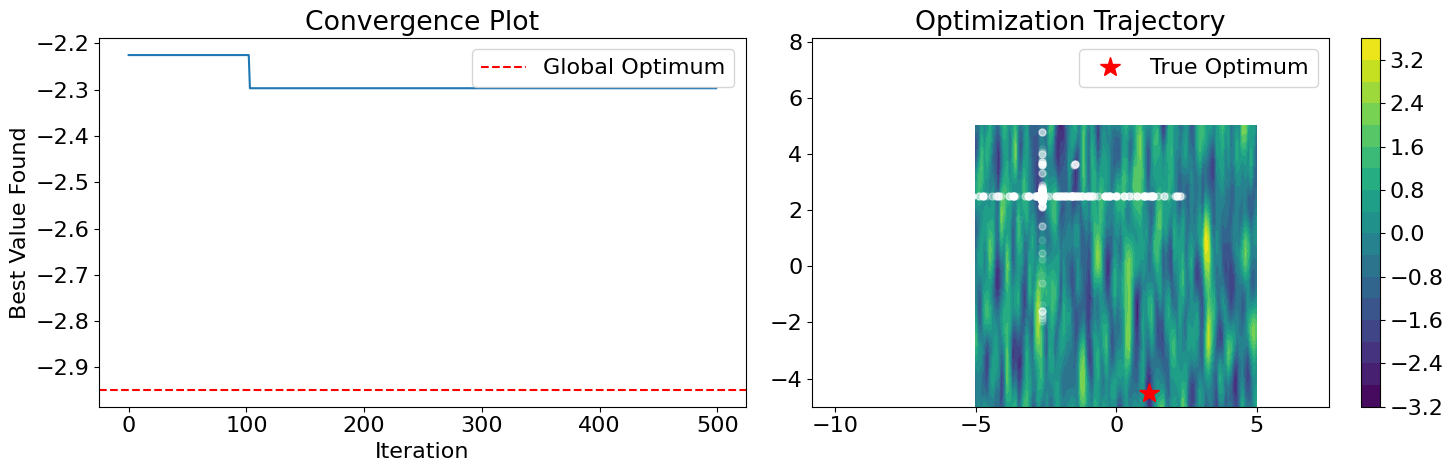

In [74]:
plot_optimization_trajectory()

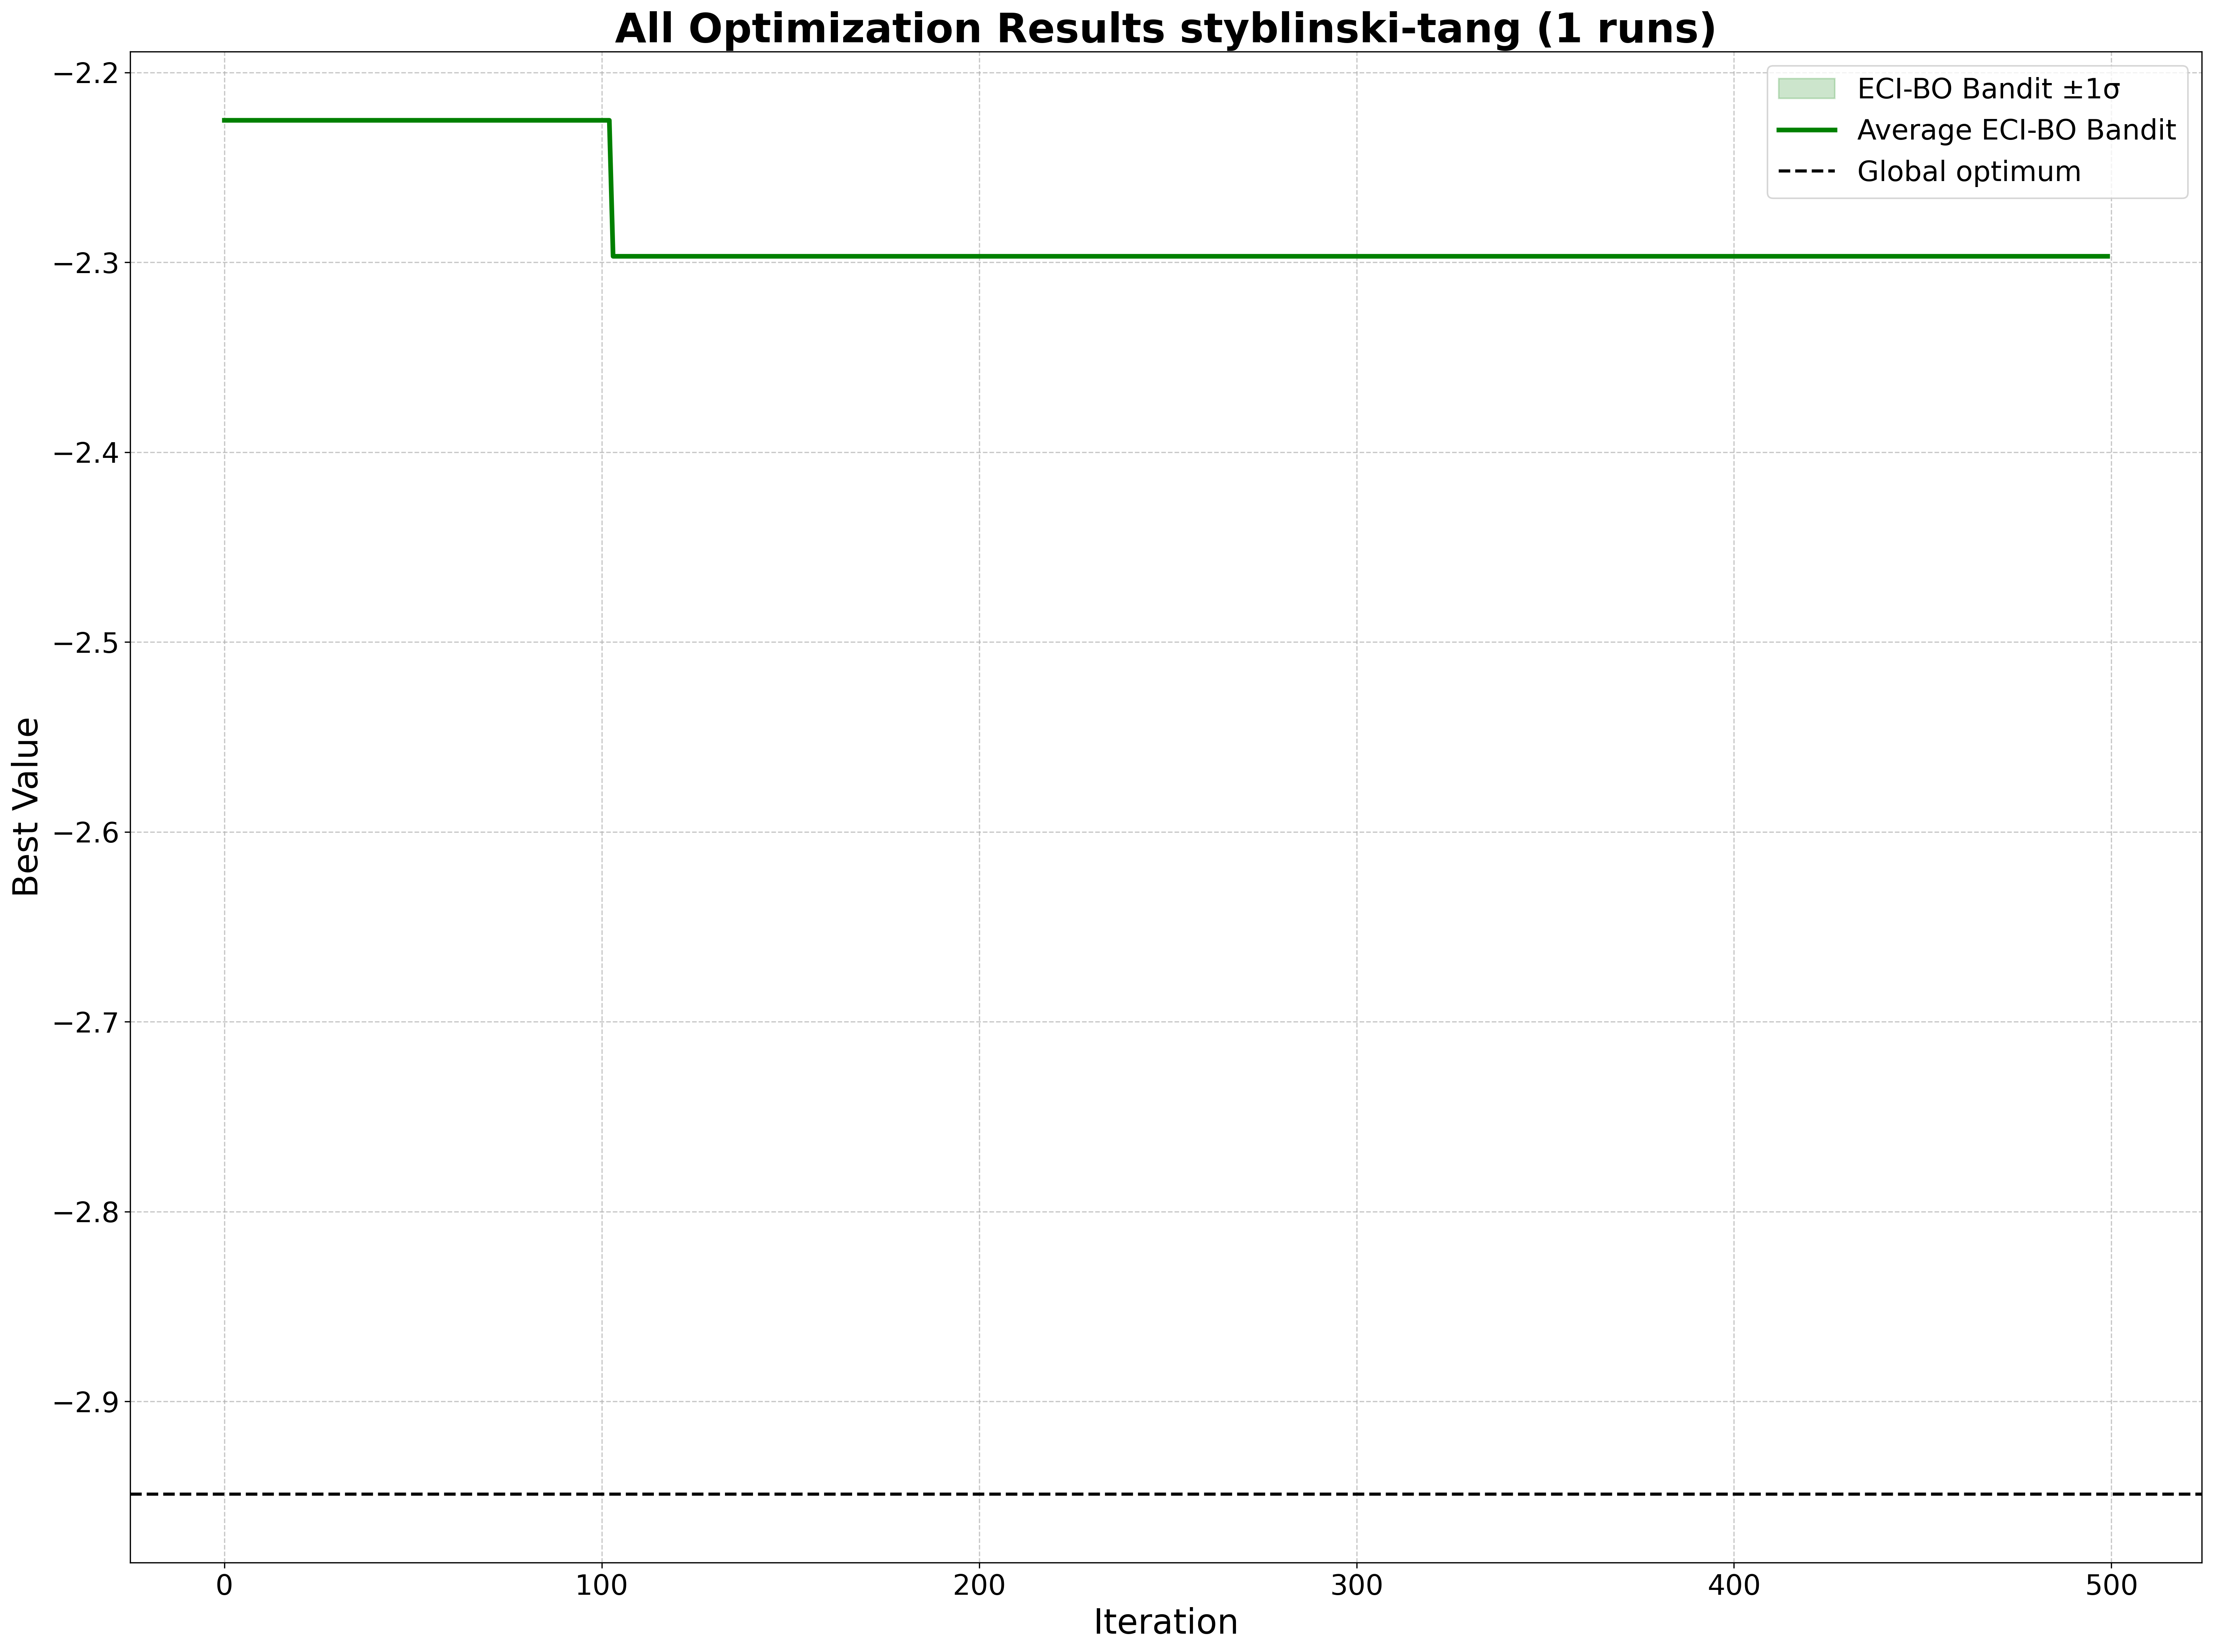

In [75]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15), dpi=300)
plt.rcParams.update({'font.size': 16})

# Calculate mean and standard deviation for each method
def calculate_confidence_bands(histories):
    histories_array = np.array(histories)
    mean = np.mean(histories_array, axis=0)
    std = np.std(histories_array, axis=0)
    return mean, mean - std, mean + std

# ECI-BO Bandit
mean_bandit, lower_bandit, upper_bandit = calculate_confidence_bands(eci_bo_bandit_history)
# Plot individual runs
for history in eci_bo_bandit_history:
    plt.plot(history, color='green', alpha=0.1)
# Plot confidence band and mean
plt.fill_between(range(len(mean_bandit)), lower_bandit, upper_bandit,
                 color='green', alpha=0.2, label='ECI-BO Bandit ±1σ')
plt.plot(mean_bandit, label="Average ECI-BO Bandit", color='green', linewidth=3)

# Global optimum line
plt.axhline(global_optimum, color="black", linestyle="--", label="Global optimum", linewidth=2)

# Customize plot
plt.xlabel("Iteration", fontsize=22)
plt.ylabel("Best Value", fontsize=22)
plt.title(f"All Optimization Results styblinski-tang ({n_runs} runs)", fontsize=26, fontweight='bold')
plt.legend(fontsize=18, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()

# Save the plot
plt.savefig('optimization_results_complete.png', dpi=300, bbox_inches='tight')